In [1]:
import pandas as pd
import xarray as xr
import numpy as np
from typing import Final
import matplotlib.pyplot as plt
from pv_forecast import fourier
import torch
from torch import nn
import torch.nn.functional as F
import torch.utils.data
import pytorch_lightning as pl
plt.rcParams['figure.figsize'] = [20, 10]

In [2]:
FILENAME: Final[str] = "gs://solar-pv-nowcasting-data/PV/GSP/v5/pv_gsp.zarr"

def load_normalized_national_pv(filename: str) -> pd.Series:
    NATIONAL_GSP_ID: Final[int] = 0
    ds = xr.open_dataset(filename, engine="zarr")
    ds = ds.sel(gsp_id=NATIONAL_GSP_ID)
    normalized_power = ds["generation_mw"] / ds["installedcapacity_mwp"]
    return normalized_power.astype(np.float32).to_series().dropna().sort_index()

In [3]:
class NationalPVDataset(torch.utils.data.Dataset):
    def __init__(self, gsp_filename: str, train: bool):
        normalized_national_pv = load_normalized_national_pv(gsp_filename)
        
        # Select train or test data
        last_date = normalized_national_pv.index[-1]
        assert (last_date - normalized_national_pv.index[0]) > pd.Timedelta(365 * 2, unit="days"), "The dataset must have at least 2 years of data!"
        one_year_before_last_date = last_date - pd.Timedelta(365, unit="days")
        if train:
            self.normalized_national_pv = normalized_national_pv[:one_year_before_last_date]
        else:
            self.normalized_national_pv = normalized_national_pv[one_year_before_last_date:]
        
        # Generate input features
        self.input_features = fourier.fourier_encode_date_time(self.normalized_national_pv.index).astype(np.float32)
        
    def __len__(self) -> int:
        return len(self.normalized_national_pv)
    
    def __getitem__(self, idx: int) -> tuple[np.ndarray, np.ndarray]:
        target = self.normalized_national_pv.iloc[idx]
        input_features = self.input_features.iloc[idx].values
        return input_features, target

In [4]:
class NationalPVModel(pl.LightningModule):
    
    def __init__(self, n_inputs: int = 6):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features=n_inputs, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=8),
            nn.ReLU(),
            nn.Linear(in_features=8, out_features=1),
            nn.ReLU(),
        )
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "train")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "val")

    def step(self, batch, batch_idx, tag: str):
        x, y = batch
        model_output = self(x).squeeze()
        mse_loss = F.mse_loss(y, model_output)
        self.log(f"{tag}/MSE", mse_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log(f"{tag}/NMAE", F.l1_loss(y, model_output), on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return mse_loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)


In [5]:
BATCH_SIZE: Final[int] = 64

train_loader = torch.utils.data.DataLoader(NationalPVDataset(FILENAME, train=True), batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(NationalPVDataset(FILENAME, train=False), batch_size=BATCH_SIZE)

trainer = pl.Trainer(max_epochs=-1)
model = NationalPVModel()

trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/jack/miniconda3/envs/pv_forecast/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 9.3 K 
-------------------------------------
9.3 K     Trainable params
0         Non-trainable params
9.3 K     Total params
0.037     Total estimated model params size 

Sanity Checking: 0it [00:00, ?it/s]

/home/jack/miniconda3/envs/pv_forecast/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/jack/miniconda3/envs/pv_forecast/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
test_loader = torch.utils.data.DataLoader(NationalPVDataset(FILENAME, train=False), batch_size=BATCH_SIZE)
test_loader_iter = iter(test_loader)

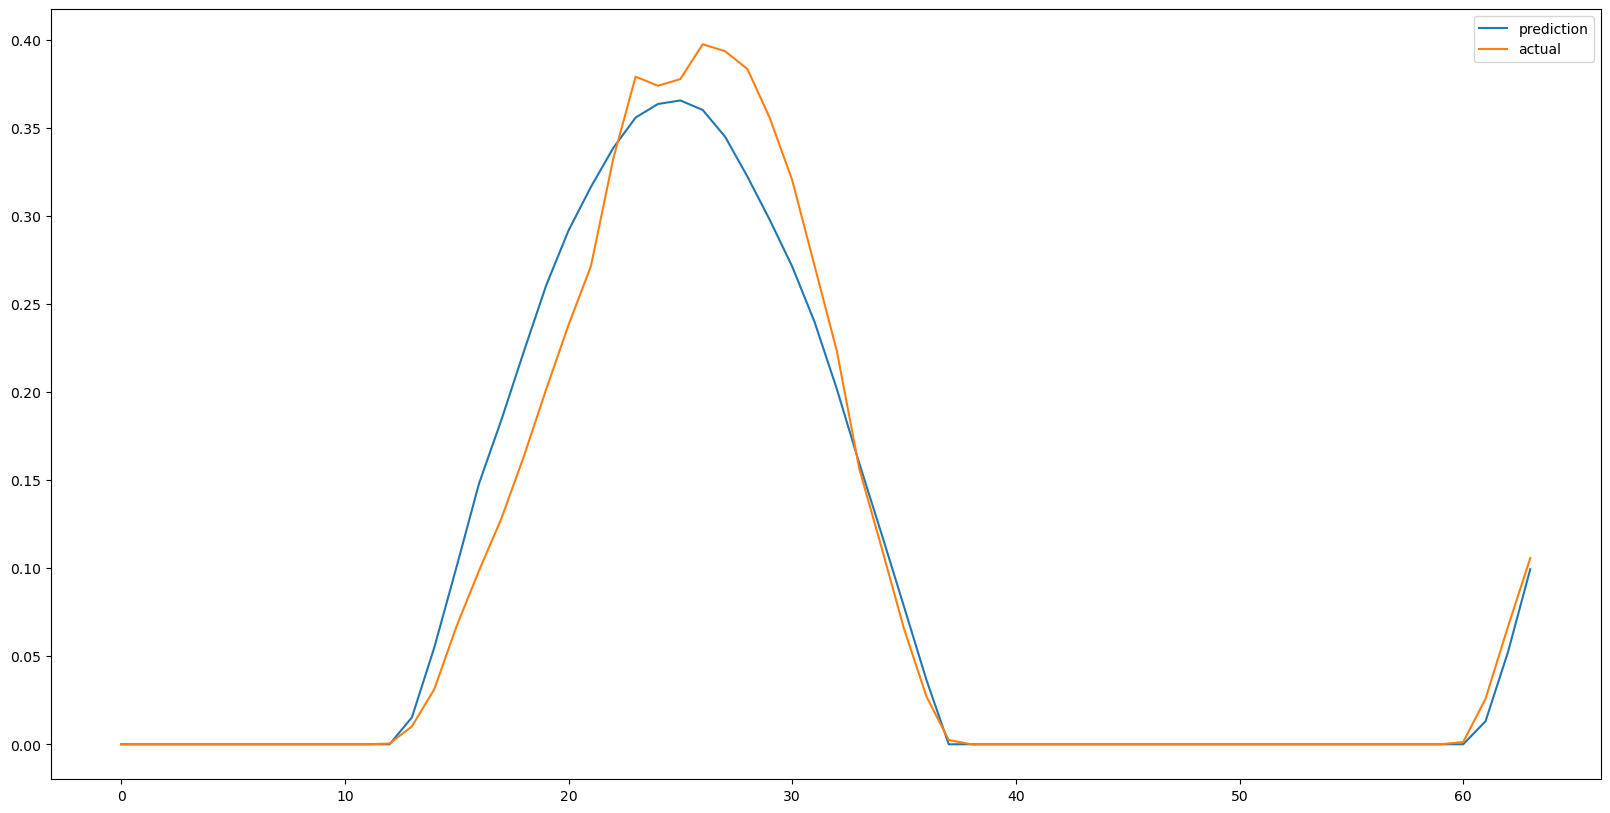

In [ ]:
test_x, test_y = next(test_loader_iter)
model_output = model(test_x)

fig, axes = plt.subplots()

ax = axes
ax.plot(model_output.squeeze().detach(), label="prediction")
ax.plot(test_y, label="actual")
ax.legend()